# Demo: Denoising of 2D simulated images

This notebook showcases the training of an SN2N 2DUnet model for a 2D denoising task using simulated MT data generated by ourselves.

In [1]:
import os
import sys
import numpy as np
sys.path.append(os.path.abspath(r'E:\PreStudy\02Source\SN2N'))  # 添加搜索路径
from SN2N.datagen import generator2D
from SN2N.get_options import datagen2D

## Simulated data

We created microtubule-like structures by utilizing the insertShape function in MATLAB to draw multiple lines with random orientations. The simulation included the effects of incomplete labeling observed in practical experiments through the application of a small Gaussian mask and elastic deformation, mimicking the curviness of the cytoskeleton. The synthetic structures were convolved with a 150 nm size PSF and downsampled by 2-fold, resulting in 2048 x 2048 pixels with a 32.5 nm pixel size (simulated blurred ground-truth).A photon count of 50 a.u. (Level 2) was assigned to the synthetic structures for intensity emissions. Subsequently, Poisson noise injection was applied, followed by the addition of Gaussian readout noise with a fixed amplitude of 25 a.u. **The 2D dataset can be found at 'examples/denoising2D' path.**

我们利用 MATLAB 中的 insertShape 函数绘制多条具有随机方向的线，从而创建了类似微管的结构。模拟包括在实际实验中通过应用小高斯掩码和弹性变形观察到的不完全标记的影响，模拟细胞骨架的弯曲度。合成结构用 150 nm 大小的 PSF 进行卷积，并下采样 2 倍，得到 2048 x 2048 像素和 32.5 nm 像素大小（模拟模糊的地面实况）。将 50 a.u.（2 级）的光子数分配给强度发射的合成结构。随后，应用泊松噪声注入，然后添加固定振幅为 25 a.u. 的高斯读出噪声。**2D 数据集可以在 'examples/denoising2D' 路径中找到。**

<p>
<img src='./imgs/simulation-workflow.png' align="left" width=500>
</p>

## Generating training data for SN2N

We first need to use raw_data to generate SN2N data pairs.  
When generating data pairs, we need to first confirm and <font color="red">set important parameters</font> related to data generation.

-----Parameters------  
<font color="red">=====Important==========</font>  
- <span style="color:blue">img_path:</span>  
    Path of raw images to train.  
- <span style="color:blue">P2Pmode(0 ~ 3):</span>  
    Augmentation mode for Patch2Patch.  
    0: NONE;  
    1: Direct interchange in t;  
    2: Interchange in single frame;  
    3: Interchange in multiple frame but in different regions;  
    {default: 0}  
- <span style="color:blue">P2Pup:</span>  
    Increase the dataset to its (1 + P2Pup) times size.  
    {default: 0}  
- <span style="color:blue">BAmode(0 ~ 2)</span>  
    Basic augmentation mode.  
    0: NONE;  
    1: double the dataset with random rotate&flip;  
    2: eightfold the dataset with random rotate&flip;  
    {default: 0}  
- <span style="color:blue">SWsize</span>  
    Interval pixel of sliding window for generating image pathes.  
    {default: 64}  
    
<font color="red">======Other parameters do not require modification; for details, refer to SN2N.get_options.datagen2D.========</font>  


#### Step 1: Define custom parameters.
We use one raw image and apply both P2P augmentation and basic augmentation to demonstrate SN2N's ability to denoise using only one original noisy image. 

In [2]:
img_path = 'data/raw_data'
P2Pmode = '2'
P2Pup = '6'
BAmode = '2'
SWsize = '64' 


datagen2D_args = [
    '--img_path', img_path,
    '--P2Pmode', P2Pmode,
    '--P2Pup', P2Pup,
    '--BAmode', BAmode,
    '--SWsize', SWsize        
]

args = datagen2D(datagen2D_args)
print("Arguments received:", args)

Arguments received: Namespace(BAmode=2, P2Pmode=2, P2Ppatch='64', P2Pup=6, SWfilter=1, SWmode=1, SWsize=64, ifx2=True, img_patch='128', img_path='data/raw_data', inter_mode='Fourier')


#### Step 2: Execute data generation.

The <font color="red">raw data</font> used for generating training data is stored in the <font color="red">'Path:/raw_data'</font> directory, and the generated <font color="red">training data pairs</font> are by default stored in the <font color="red">'Path:/datasets'</font>

In [4]:
d = generator2D(img_path=args.img_path, P2Pmode = args.P2Pmode, P2Pup = args.P2Pup, BAmode = args.BAmode, SWsize = args.SWsize)
d.execute()
print("Data generation completed.")

The path for the raw images used for training is located under:
data/raw_data
The training dataset is being saved under:
data\datasets
For number 1 frame
Saving training images: 100
Saving training images: 200
Saving training images: 300
Saving training images: 400
Saving training images: 500
Saving training images: 600
Saving training images: 700
Saving training images: 800
Saving training images: 900
Saving training images: 1000
Saving training images: 1100
Saving training images: 1200
Saving training images: 1300
Saving training images: 1400
Saving training images: 1500
Saving training images: 1600
Saving training images: 1700
Saving training images: 1800
Saving training images: 1900
Saving training images: 2000
Saving training images: 2100
Saving training images: 2200
Saving training images: 2300
Saving training images: 2400
Saving training images: 2500
Saving training images: 2600
Saving training images: 2700
Saving training images: 2800
Saving training images: 2900
Saving trainin

## Show some generated patches

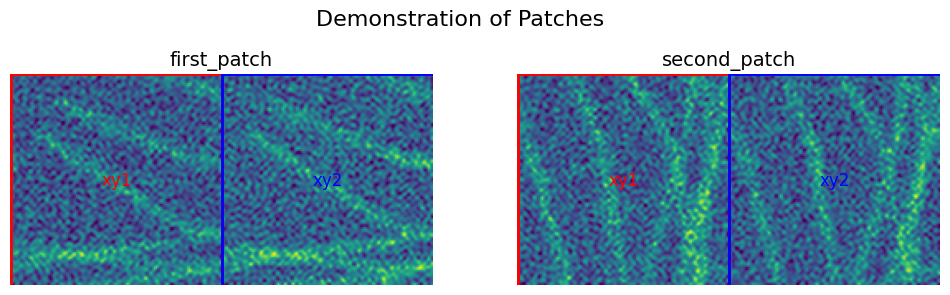

In [5]:
import tifffile
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

dataset_path = d.dataset_path
tif_files = [f for f in os.listdir(dataset_path) if f.endswith('.tif')]
first_patch = tifffile.imread(os.path.join(dataset_path, tif_files[0]))
second_patch = tifffile.imread(os.path.join(dataset_path, tif_files[1]))

fig, axs = plt.subplots(1, 2, figsize=(12, 3.5))


im1 = axs[0].imshow(first_patch)
axs[0].set_title('first_patch', fontsize=14)
axs[0].axis('off') 
axs[0].add_patch(Rectangle((0, 0), first_patch.shape[1] // 2, first_patch.shape[0], linewidth=2, edgecolor='r', facecolor='none'))
axs[0].add_patch(Rectangle((first_patch.shape[1] // 2, 0), first_patch.shape[1] // 2, first_patch.shape[0], linewidth=2, edgecolor='b', facecolor='none'))


axs[0].text(first_patch.shape[1] // 4, first_patch.shape[0] // 2, 'xy1', fontsize=12, color='r', ha='center', va='center')
axs[0].text(3 * first_patch.shape[1] // 4, first_patch.shape[0] // 2, 'xy2', fontsize=12, color='b', ha='center', va='center')


im2 = axs[1].imshow(second_patch)
axs[1].set_title('second_patch', fontsize=14)
axs[1].axis('off') 
axs[1].add_patch(Rectangle((0, 0), second_patch.shape[1] // 2, second_patch.shape[0], linewidth=2, edgecolor='r', facecolor='none'))
axs[1].add_patch(Rectangle((second_patch.shape[1] // 2, 0), second_patch.shape[1] // 2, second_patch.shape[0], linewidth=2, edgecolor='b', facecolor='none'))


axs[1].text(second_patch.shape[1] // 4, second_patch.shape[0] // 2, 'xy1', fontsize=12, color='r', ha='center', va='center')
axs[1].text(3 * second_patch.shape[1] // 4, second_patch.shape[0] // 2, 'xy2', fontsize=12, color='b', ha='center', va='center')


fig.suptitle('Demonstration of Patches', fontsize=16)


plt.show()

## Training data

We need to use training data pairs to train SN2N model.  
When training, we need to first confirm and <font color="red">set important parameters</font> related to trainers.

-----Parameters------  
<font color="red">=====Important==========</font>  
- <span style="color:blue">img_path:</span>  
    Path of raw images to train.  
- <span style="color:blue">sn2n_loss:</span>  
    Weight of self-constrained loss.  
    <span style="color:red">One of the most crucial parameters that needs adjustment， generally set to 0~2.</span>  
    A higher sn2n_loss weight implies relatively better denoising and more pronounced smoothing effects.  
    {default: 1}  
- <span style="color:blue">bs:</span>  
    Training batch size.  
    {default: 32}  
- <span style="color:blue">lr</span>  
    Learning rate.       
    {default: 2e-4}  
- <span style="color:blue">epochs</span>  
    Total number of training epochs.  
    {default: 100}  
    
<font color="red">======Other parameters do not require modification; for details, refer to SN2N.get_options.trainer2D.========</font>  

#### Step 1: Define custom parameters.

In [6]:
from SN2N.trainer import net2D
from SN2N.get_options import trainer2D

img_path = 'data/raw_data'
sn2n_loss = '1'
bs = '32'
lr = '2e-4'
# epochs = '100'
epochs = '1'

trainer2D_args = [
    '--img_path', img_path,
    '--sn2n_loss', sn2n_loss,
    '--bs', bs,
    '--lr', lr,
    '--epochs', epochs
]

args = trainer2D(trainer2D_args)
print("Arguments received:", args)

Arguments received: Namespace(bs=32, epochs=1, if_alr=True, img_patch='128', img_path='data/raw_data', lr=0.0002, sn2n_loss=1.0)


#### Step 2: Execute training.

The <font color="red">raw data</font> used for generating training data is stored in the <font color="red">'Path:/raw_data'</font> directory  
the <font color="red">models</font> are by default stored in the <font color="red">'Path:/models'</font>  
During the training process, we also performed real-time predictions for the first image in the raw_data for each epoch as predicted images. The <font color="red">images</font> results are by default stored in the <font color="red">'Path:/images'</font> directory.

In [7]:
sn2nunet = net2D(img_path = args.img_path, sn2n_loss = args.sn2n_loss, bs = args.bs, lr = args.lr, epochs = args.epochs)
sn2nunet.train()
print("Training completed.")

d:\Software\anaconda3\envs\SN2N\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


The path for the raw images used for training is located under:
data/raw_data
The training dataset is being saved under:
data\datasets
Models is being saved under:
data\models
Training temporary prediction images is being saved under:
data\images
[Epoch 0/1] [Batch 0/842] [loss:16.461936] time:0:00:01.984367
[Epoch 0/1] [Batch 1/842] [loss:15.132183] time:0:00:02.032922
[Epoch 0/1] [Batch 2/842] [loss:13.814771] time:0:00:02.068560
[Epoch 0/1] [Batch 3/842] [loss:12.757351] time:0:00:02.099513
[Epoch 0/1] [Batch 4/842] [loss:12.015368] time:0:00:02.132054
[Epoch 0/1] [Batch 5/842] [loss:11.901223] time:0:00:02.149773
[Epoch 0/1] [Batch 6/842] [loss:10.129182] time:0:00:02.184382
[Epoch 0/1] [Batch 7/842] [loss:9.656601] time:0:00:02.235403
[Epoch 0/1] [Batch 8/842] [loss:10.456409] time:0:00:02.269999
[Epoch 0/1] [Batch 9/842] [loss:9.643721] time:0:00:02.300588
[Epoch 0/1] [Batch 10/842] [loss:9.683635] time:0:00:02.316511
[Epoch 0/1] [Batch 11/842] [loss:9.439345] time:0:00:02.366964

## Show some prediction images

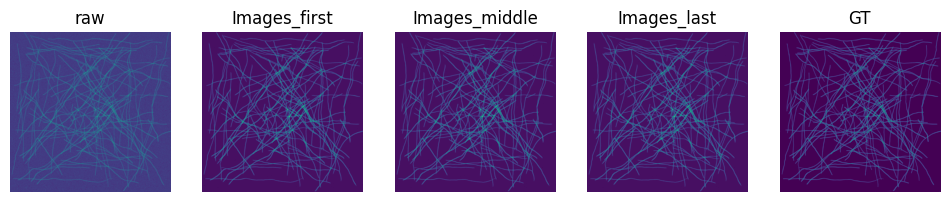

In [11]:
images_path = sn2nunet.images_path
tif_files = [f for f in os.listdir(images_path) if f.endswith('.tif')]
middle_index = len(tif_files) // 2

images_first = np.squeeze(tifffile.imread(os.path.join(images_path, tif_files[0])))
images_middle = np.squeeze(tifffile.imread(os.path.join(images_path, tif_files[middle_index])))
images_last = np.squeeze(tifffile.imread(os.path.join(images_path, tif_files[-1])))

# raw = tifffile.imread('imgs/levelTWO_1.tif')
# GT = tifffile.imread('imgs/gt.tif')
raw = Image.open('data/raw_data/levelTWO_1.tif')
GT = Image.open('data/gt/1.tif')

fig, axs = plt.subplots(1, 5, figsize=(12, 4))

axs[0].imshow(raw, cmap='viridis')
axs[0].set_title('raw')
axs[0].axis('off')

axs[1].imshow(images_first, cmap='viridis')
axs[1].set_title('Images_first')
axs[1].axis('off')

axs[2].imshow(images_middle, cmap='viridis')
axs[2].set_title('Images_middle')
axs[2].axis('off')

axs[3].imshow(images_last, cmap='viridis')
axs[3].set_title('Images_last')
axs[3].axis('off')

axs[4].imshow(GT, cmap='viridis')
axs[4].set_title('GT')
axs[4].axis('off')

plt.show()

## Display the loss curve during training.

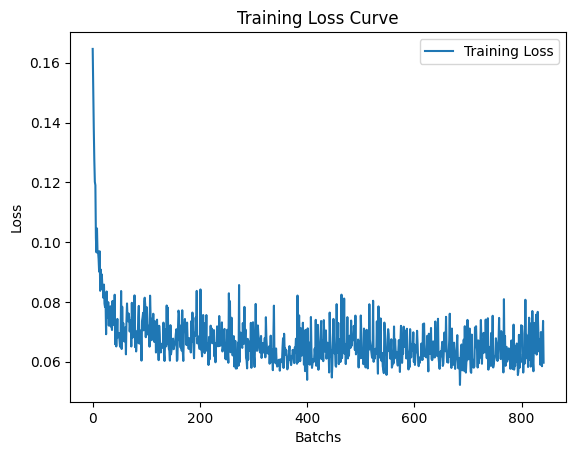

In [9]:
def plot_loss_curve(loss_history):
    plt.plot(loss_history, label='Training Loss')
    plt.title('Training Loss Curve')
    plt.xlabel('Batchs')
    plt.ylabel('Loss')
#     plt.axis('off') 
    plt.legend()
    plt.show()

parent_path = sn2nunet.parent_dir
tif_files = [f for f in os.listdir(parent_path) if f.endswith('loss.txt')]
file_path = os.path.join(parent_path, tif_files[0])
with open(file_path, 'r') as f:
    loss_history = [float(line.strip()) for line in f if line.strip()]
plot_loss_curve(loss_history)